In [225]:
import os
import numpy as np
import tensorflow as tf
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
%matplotlib inline

# Get data

In [314]:
IMG_SIZE = 32
FEATURE_SIZE = 50

In [315]:
def load_img(path):
    img = skimage.io.imread(path)
    img = img / 255.0
    # print "Original Image Shape: ", img.shape
    # we crop image from center
    short_edge = min(img.shape[:2])
    yy = int((img.shape[0] - short_edge) / 2)
    xx = int((img.shape[1] - short_edge) / 2)
    crop_img = img[yy: yy + short_edge, xx: xx + short_edge]
    # resize to 224, 224
    resized_img = skimage.transform.resize(crop_img, (IMG_SIZE, IMG_SIZE))[None, :, :, :]   # shape [1, 224, 224, 3]
#    resized_img = skimage.transform.resize(crop_img, (32, 32))[None, :, :, :]   # shape [1, 32, 32, 3]
    return resized_img

In [316]:
def load_data(image_dir, part_dir_list):
    image_list = []
    label_list = []
    feat_list = []
    for k in range(len(part_dir_list)):
        part_name = part_dir_list[k]
        dir = image_dir + part_name
        for file in os.listdir(dir):
            if not file.lower().endswith('.jpg'):
                continue
            try:
                resized_img = load_img(os.path.join(dir, file))
            except OSError:
                continue
            image_list.append(resized_img)    # [1, height, width, depth] * n
            
            tag = np.zeros((1, len(part_dir_list)))
            tag[0][k] = 1
            label_list.append(tag)
            
            feature = np.full((1, FEATURE_SIZE), k/1.0)
            feat_list.append(feature)

#            if len(imgs[k]) == 400:        # only use 400 imgs to reduce my memory load
#                break
    
    image_data = np.concatenate(image_list, axis=0)
    label_data = np.concatenate(label_list, axis=0)
    feat_data = np.concatenate(feat_list, axis=0)
    
    return image_data, label_data, feat_data

In [317]:
train_image_dir = 'train_img/'
test_image_dir = 'test_img/'

In [318]:
part_list = ['out', 'in']

In [319]:
train_dataset, label_dataset, feature_dataset = load_data(train_image_dir, part_dir_list=part_list)
test_dataset, test_label, test_feature = load_data(test_image_dir, part_dir_list=part_list)

/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


In [320]:
train_dataset.shape

(96, 32, 32, 3)

In [321]:
label_dataset
label_dataset.shape
label_dataset[2]

array([ 1.,  0.])

In [322]:
feature_dataset.shape
#train_feature[55]

(96, 50)

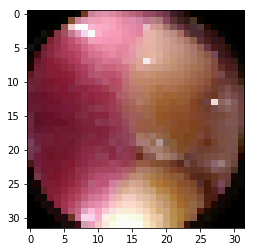

In [323]:
plt.imshow(train_dataset[2])

# Model

In [324]:
import tensorflow as tf

In [345]:
x = tf.placeholder(tf.float32,shape=[None, IMG_SIZE, IMG_SIZE, 3])
#x = tf.placeholder(tf.float32,shape=[None,32,32,3])
y_true = tf.placeholder(tf.float32,shape=[None,len(part_list)])
x_feat = tf.placeholder(tf.float32,shape=[None,FEATURE_SIZE])

In [346]:
hold_prob = tf.placeholder(tf.float32)

In [347]:
def init_weights(shape):
    init_random_dist = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(init_random_dist)

def init_bias(shape):
    init_bias_vals = tf.constant(0.1, shape=shape)
    return tf.Variable(init_bias_vals)

def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2by2(x):
    return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                          strides=[1, 2, 2, 1], padding='SAME')

def convolutional_layer(input_x, shape):
    W = init_weights(shape)
    b = init_bias([shape[3]])
    return tf.nn.relu(conv2d(input_x, W) + b)

def normal_full_layer(input_layer, size):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, size])
    b = init_bias([size])
    return tf.matmul(input_layer, W) + b

# Create layers

In [348]:
convo_1 = convolutional_layer(x,shape=[4,4,3,32])
convo_1_pooling = max_pool_2by2(convo_1)

In [349]:
convo_2 = convolutional_layer(convo_1_pooling,shape=[4,4,32,64])
convo_2_pooling = max_pool_2by2(convo_2)

In [350]:
#convo_2_flat = tf.reshape(convo_2_pooling, [-1, 8*8*64])  #example
size = (int)(IMG_SIZE/4)
convo_2_flat = tf.reshape(convo_2_pooling, [-1, size*size*64])

In [351]:
#convo_2_flat_ext = tf.concat( [convo_2_flat, x_feat ], 1 )

In [352]:
full_layer_one = tf.nn.relu(normal_full_layer(convo_2_flat, 1024))

In [353]:
full_one_dropout = tf.nn.dropout(full_layer_one,keep_prob=hold_prob)

In [354]:
full_feature = tf.concat( [full_one_dropout, x_feat], 1 )

In [355]:
#y_pred = normal_full_layer(full_one_dropout,len(part_list))
y_pred = normal_full_layer(full_feature, len(part_list))

In [356]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true,logits=y_pred))

In [357]:
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
train = optimizer.minimize(cross_entropy)

In [358]:
init = tf.global_variables_initializer()

# Graph session

In [359]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    index = 0
    saver = tf.train.Saver()
    save_path='./output/teeth_learn'

    for i in range(5000):
        batch_size = 2
        x_dataset = train_dataset[index:index+batch_size].reshape(-1, IMG_SIZE, IMG_SIZE, 3)
        y_dataset = label_dataset[index:index+batch_size].reshape(-1, len(part_list))
        f_dataset = feature_dataset[index:index+batch_size].reshape(-1, FEATURE_SIZE)

        
        index = (index+batch_size) % len(train_dataset)
        
        sess.run(train, feed_dict={x: x_dataset, y_true: y_dataset, x_feat: f_dataset, hold_prob: 0.5})
        
        # PRINT OUT A MESSAGE EVERY 100 STEPS
        if i%100 == 0:
            
            print('Currently on step {}'.format(i))
            print('Accuracy is:')
            # Test the Train Model
            matches = tf.equal(tf.argmax(y_pred,1),tf.argmax(y_true,1))

            acc = tf.reduce_mean(tf.cast(matches,tf.float32))

            print(sess.run(acc,feed_dict={x:test_dataset, y_true:test_label, x_feat:test_feature, hold_prob:1.0}))
            print('\n')
            
            saver.save(sess, save_path, write_meta_graph=False)

y shape =  (2, 2)
f shape =  (2, 50)
Currently on step 0
Accuracy is:
0.5




ResourceExhaustedError: output/teeth_learn.data-00000-of-00001.tempstate13710403035858702885; No space left on device
	 [[Node: save_23/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_23/Const_0_0, save_23/SaveV2/tensor_names, save_23/SaveV2/shape_and_slices, Variable, Variable/Adam, Variable/Adam_1, Variable_1, Variable_1/Adam, Variable_1/Adam_1, Variable_10, Variable_10/Adam, Variable_10/Adam_1, Variable_11, Variable_11/Adam, Variable_11/Adam_1, Variable_12, Variable_12/Adam, Variable_12/Adam_1, Variable_13, Variable_13/Adam, Variable_13/Adam_1, Variable_14, Variable_14/Adam, Variable_14/Adam_1, Variable_15, Variable_15/Adam, Variable_15/Adam_1, Variable_16, Variable_16/Adam, Variable_16/Adam_1, Variable_17, Variable_17/Adam, Variable_17/Adam_1, Variable_18, Variable_18/Adam, Variable_18/Adam_1, Variable_19, Variable_19/Adam, Variable_19/Adam_1, Variable_2, Variable_2/Adam, Variable_2/Adam_1, Variable_20, Variable_20/Adam, Variable_20/Adam_1, Variable_21, Variable_21/Adam, Variable_21/Adam_1, Variable_22, Variable_22/Adam, Variable_22/Adam_1, Variable_23, Variable_23/Adam, Variable_23/Adam_1, Variable_24, Variable_24/Adam, Variable_24/Adam_1, Variable_24/Adam_2, Variable_24/Adam_3, Variable_25, Variable_25/Adam, Variable_25/Adam_1, Variable_25/Adam_2, Variable_25/Adam_3, Variable_26, Variable_26/Adam, Variable_26/Adam_1, Variable_26/Adam_2, Variable_26/Adam_3, Variable_27, Variable_27/Adam, Variable_27/Adam_1, Variable_27/Adam_2, Variable_27/Adam_3, Variable_28, Variable_28/Adam, Variable_28/Adam_1, Variable_29, Variable_29/Adam, Variable_29/Adam_1, Variable_3, Variable_3/Adam, Variable_3/Adam_1, Variable_30, Variable_30/Adam, Variable_30/Adam_1, Variable_31, Variable_31/Adam, Variable_31/Adam_1, Variable_32, Variable_32/Adam, Variable_32/Adam_1, Variable_33, Variable_33/Adam, Variable_33/Adam_1, Variable_34, Variable_34/Adam, Variable_34/Adam_1, Variable_35, Variable_35/Adam, Variable_35/Adam_1, Variable_36, Variable_36/Adam, Variable_36/Adam_1, Variable_37, Variable_37/Adam, Variable_37/Adam_1, Variable_38, Variable_38/Adam, Variable_38/Adam_1, Variable_39, Variable_39/Adam, Variable_39/Adam_1, Variable_4, Variable_4/Adam, Variable_4/Adam_1, Variable_40, Variable_40/Adam, Variable_40/Adam_1, Variable_41, Variable_41/Adam, Variable_41/Adam_1, Variable_42, Variable_42/Adam, Variable_42/Adam_1, Variable_43, Variable_43/Adam, Variable_43/Adam_1, Variable_44, Variable_44/Adam, Variable_44/Adam_1, Variable_44/Adam_2, Variable_44/Adam_3, Variable_45, Variable_45/Adam, Variable_45/Adam_1, Variable_45/Adam_2, Variable_45/Adam_3, Variable_46, Variable_46/Adam, Variable_46/Adam_1, Variable_46/Adam_2, Variable_46/Adam_3, Variable_47, Variable_47/Adam, Variable_47/Adam_1, Variable_47/Adam_2, Variable_47/Adam_3, Variable_48, Variable_48/Adam, Variable_48/Adam_1, Variable_49, Variable_49/Adam, Variable_49/Adam_1, Variable_5, Variable_5/Adam, Variable_5/Adam_1, Variable_50, Variable_50/Adam, Variable_50/Adam_1, Variable_51, Variable_51/Adam, Variable_51/Adam_1, Variable_52, Variable_52/Adam, Variable_52/Adam_1, Variable_53, Variable_53/Adam, Variable_53/Adam_1, Variable_54, Variable_54/Adam, Variable_54/Adam_1, Variable_55, Variable_55/Adam, Variable_55/Adam_1, Variable_56, Variable_56/Adam, Variable_56/Adam_1, Variable_57, Variable_57/Adam, Variable_57/Adam_1, Variable_58, Variable_58/Adam, Variable_58/Adam_1, Variable_59, Variable_59/Adam, Variable_59/Adam_1, Variable_6, Variable_6/Adam, Variable_6/Adam_1, Variable_60, Variable_60/Adam, Variable_60/Adam_1, Variable_61, Variable_61/Adam, Variable_61/Adam_1, Variable_62, Variable_62/Adam, Variable_62/Adam_1, Variable_63, Variable_63/Adam, Variable_63/Adam_1, Variable_64, Variable_64/Adam, Variable_64/Adam_1, Variable_64/Adam_2, Variable_64/Adam_3, Variable_65, Variable_65/Adam, Variable_65/Adam_1, Variable_65/Adam_2, Variable_65/Adam_3, Variable_66, Variable_66/Adam, Variable_66/Adam_1, Variable_66/Adam_2, Variable_66/Adam_3, Variable_67, Variable_67/Adam, Variable_67/Adam_1, Variable_67/Adam_2, Variable_67/Adam_3, Variable_68, Variable_69, Variable_7, Variable_7/Adam, Variable_7/Adam_1, Variable_70, Variable_70/Adam, Variable_70/Adam_1, Variable_70/Adam_2, Variable_70/Adam_3, Variable_71, Variable_71/Adam, Variable_71/Adam_1, Variable_71/Adam_2, Variable_71/Adam_3, Variable_72, Variable_72/Adam, Variable_72/Adam_1, Variable_73, Variable_73/Adam, Variable_73/Adam_1, Variable_74, Variable_75, Variable_76, Variable_76/Adam, Variable_76/Adam_1, Variable_77, Variable_77/Adam, Variable_77/Adam_1, Variable_78, Variable_78/Adam, Variable_78/Adam_1, Variable_79, Variable_79/Adam, Variable_79/Adam_1, Variable_8, Variable_8/Adam, Variable_8/Adam_1, Variable_80, Variable_80/Adam, Variable_80/Adam_1, Variable_81, Variable_81/Adam, Variable_81/Adam_1, Variable_82, Variable_82/Adam, Variable_82/Adam_1, Variable_83, Variable_83/Adam, Variable_83/Adam_1, Variable_84, Variable_84/Adam, Variable_84/Adam_1, Variable_85, Variable_85/Adam, Variable_85/Adam_1, Variable_86, Variable_86/Adam, Variable_86/Adam_1, Variable_87, Variable_87/Adam, Variable_87/Adam_1, Variable_88, Variable_88/Adam, Variable_88/Adam_1, Variable_89, Variable_89/Adam, Variable_89/Adam_1, Variable_9, Variable_9/Adam, Variable_9/Adam_1, Variable_90, Variable_90/Adam, Variable_90/Adam_1, Variable_91, Variable_91/Adam, Variable_91/Adam_1, Variable_92, Variable_92/Adam, Variable_92/Adam_1, Variable_93, Variable_93/Adam, Variable_93/Adam_1, beta1_power, beta1_power_1, beta1_power_10, beta1_power_11, beta1_power_12, beta1_power_2, beta1_power_3, beta1_power_4, beta1_power_5, beta1_power_6, beta1_power_7, beta1_power_8, beta1_power_9, beta2_power, beta2_power_1, beta2_power_10, beta2_power_11, beta2_power_12, beta2_power_2, beta2_power_3, beta2_power_4, beta2_power_5, beta2_power_6, beta2_power_7, beta2_power_8, beta2_power_9)]]

Caused by op 'save_23/SaveV2', defined at:
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-359-44e2f822d6e4>", line 4, in <module>
    saver = tf.train.Saver()
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1218, in __init__
    self.build()
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1227, in build
    self._build(self._filename, build_save=True, build_restore=True)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1263, in _build
    build_save=build_save, build_restore=build_restore)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 748, in _build_internal
    save_tensor = self._AddSaveOps(filename_tensor, saveables)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 296, in _AddSaveOps
    save = self.save_op(filename_tensor, saveables)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 239, in save_op
    tensors)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 1163, in save_v2
    shape_and_slices=shape_and_slices, tensors=tensors, name=name)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2956, in create_op
    op_def=op_def)
  File "/Users/yu-hsunchen/anaconda3/envs/tfdeeplearning/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1470, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

ResourceExhaustedError (see above for traceback): output/teeth_learn.data-00000-of-00001.tempstate13710403035858702885; No space left on device
	 [[Node: save_23/SaveV2 = SaveV2[dtypes=[DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT, DT_FLOAT], _device="/job:localhost/replica:0/task:0/device:CPU:0"](_arg_save_23/Const_0_0, save_23/SaveV2/tensor_names, save_23/SaveV2/shape_and_slices, Variable, Variable/Adam, Variable/Adam_1, Variable_1, Variable_1/Adam, Variable_1/Adam_1, Variable_10, Variable_10/Adam, Variable_10/Adam_1, Variable_11, Variable_11/Adam, Variable_11/Adam_1, Variable_12, Variable_12/Adam, Variable_12/Adam_1, Variable_13, Variable_13/Adam, Variable_13/Adam_1, Variable_14, Variable_14/Adam, Variable_14/Adam_1, Variable_15, Variable_15/Adam, Variable_15/Adam_1, Variable_16, Variable_16/Adam, Variable_16/Adam_1, Variable_17, Variable_17/Adam, Variable_17/Adam_1, Variable_18, Variable_18/Adam, Variable_18/Adam_1, Variable_19, Variable_19/Adam, Variable_19/Adam_1, Variable_2, Variable_2/Adam, Variable_2/Adam_1, Variable_20, Variable_20/Adam, Variable_20/Adam_1, Variable_21, Variable_21/Adam, Variable_21/Adam_1, Variable_22, Variable_22/Adam, Variable_22/Adam_1, Variable_23, Variable_23/Adam, Variable_23/Adam_1, Variable_24, Variable_24/Adam, Variable_24/Adam_1, Variable_24/Adam_2, Variable_24/Adam_3, Variable_25, Variable_25/Adam, Variable_25/Adam_1, Variable_25/Adam_2, Variable_25/Adam_3, Variable_26, Variable_26/Adam, Variable_26/Adam_1, Variable_26/Adam_2, Variable_26/Adam_3, Variable_27, Variable_27/Adam, Variable_27/Adam_1, Variable_27/Adam_2, Variable_27/Adam_3, Variable_28, Variable_28/Adam, Variable_28/Adam_1, Variable_29, Variable_29/Adam, Variable_29/Adam_1, Variable_3, Variable_3/Adam, Variable_3/Adam_1, Variable_30, Variable_30/Adam, Variable_30/Adam_1, Variable_31, Variable_31/Adam, Variable_31/Adam_1, Variable_32, Variable_32/Adam, Variable_32/Adam_1, Variable_33, Variable_33/Adam, Variable_33/Adam_1, Variable_34, Variable_34/Adam, Variable_34/Adam_1, Variable_35, Variable_35/Adam, Variable_35/Adam_1, Variable_36, Variable_36/Adam, Variable_36/Adam_1, Variable_37, Variable_37/Adam, Variable_37/Adam_1, Variable_38, Variable_38/Adam, Variable_38/Adam_1, Variable_39, Variable_39/Adam, Variable_39/Adam_1, Variable_4, Variable_4/Adam, Variable_4/Adam_1, Variable_40, Variable_40/Adam, Variable_40/Adam_1, Variable_41, Variable_41/Adam, Variable_41/Adam_1, Variable_42, Variable_42/Adam, Variable_42/Adam_1, Variable_43, Variable_43/Adam, Variable_43/Adam_1, Variable_44, Variable_44/Adam, Variable_44/Adam_1, Variable_44/Adam_2, Variable_44/Adam_3, Variable_45, Variable_45/Adam, Variable_45/Adam_1, Variable_45/Adam_2, Variable_45/Adam_3, Variable_46, Variable_46/Adam, Variable_46/Adam_1, Variable_46/Adam_2, Variable_46/Adam_3, Variable_47, Variable_47/Adam, Variable_47/Adam_1, Variable_47/Adam_2, Variable_47/Adam_3, Variable_48, Variable_48/Adam, Variable_48/Adam_1, Variable_49, Variable_49/Adam, Variable_49/Adam_1, Variable_5, Variable_5/Adam, Variable_5/Adam_1, Variable_50, Variable_50/Adam, Variable_50/Adam_1, Variable_51, Variable_51/Adam, Variable_51/Adam_1, Variable_52, Variable_52/Adam, Variable_52/Adam_1, Variable_53, Variable_53/Adam, Variable_53/Adam_1, Variable_54, Variable_54/Adam, Variable_54/Adam_1, Variable_55, Variable_55/Adam, Variable_55/Adam_1, Variable_56, Variable_56/Adam, Variable_56/Adam_1, Variable_57, Variable_57/Adam, Variable_57/Adam_1, Variable_58, Variable_58/Adam, Variable_58/Adam_1, Variable_59, Variable_59/Adam, Variable_59/Adam_1, Variable_6, Variable_6/Adam, Variable_6/Adam_1, Variable_60, Variable_60/Adam, Variable_60/Adam_1, Variable_61, Variable_61/Adam, Variable_61/Adam_1, Variable_62, Variable_62/Adam, Variable_62/Adam_1, Variable_63, Variable_63/Adam, Variable_63/Adam_1, Variable_64, Variable_64/Adam, Variable_64/Adam_1, Variable_64/Adam_2, Variable_64/Adam_3, Variable_65, Variable_65/Adam, Variable_65/Adam_1, Variable_65/Adam_2, Variable_65/Adam_3, Variable_66, Variable_66/Adam, Variable_66/Adam_1, Variable_66/Adam_2, Variable_66/Adam_3, Variable_67, Variable_67/Adam, Variable_67/Adam_1, Variable_67/Adam_2, Variable_67/Adam_3, Variable_68, Variable_69, Variable_7, Variable_7/Adam, Variable_7/Adam_1, Variable_70, Variable_70/Adam, Variable_70/Adam_1, Variable_70/Adam_2, Variable_70/Adam_3, Variable_71, Variable_71/Adam, Variable_71/Adam_1, Variable_71/Adam_2, Variable_71/Adam_3, Variable_72, Variable_72/Adam, Variable_72/Adam_1, Variable_73, Variable_73/Adam, Variable_73/Adam_1, Variable_74, Variable_75, Variable_76, Variable_76/Adam, Variable_76/Adam_1, Variable_77, Variable_77/Adam, Variable_77/Adam_1, Variable_78, Variable_78/Adam, Variable_78/Adam_1, Variable_79, Variable_79/Adam, Variable_79/Adam_1, Variable_8, Variable_8/Adam, Variable_8/Adam_1, Variable_80, Variable_80/Adam, Variable_80/Adam_1, Variable_81, Variable_81/Adam, Variable_81/Adam_1, Variable_82, Variable_82/Adam, Variable_82/Adam_1, Variable_83, Variable_83/Adam, Variable_83/Adam_1, Variable_84, Variable_84/Adam, Variable_84/Adam_1, Variable_85, Variable_85/Adam, Variable_85/Adam_1, Variable_86, Variable_86/Adam, Variable_86/Adam_1, Variable_87, Variable_87/Adam, Variable_87/Adam_1, Variable_88, Variable_88/Adam, Variable_88/Adam_1, Variable_89, Variable_89/Adam, Variable_89/Adam_1, Variable_9, Variable_9/Adam, Variable_9/Adam_1, Variable_90, Variable_90/Adam, Variable_90/Adam_1, Variable_91, Variable_91/Adam, Variable_91/Adam_1, Variable_92, Variable_92/Adam, Variable_92/Adam_1, Variable_93, Variable_93/Adam, Variable_93/Adam_1, beta1_power, beta1_power_1, beta1_power_10, beta1_power_11, beta1_power_12, beta1_power_2, beta1_power_3, beta1_power_4, beta1_power_5, beta1_power_6, beta1_power_7, beta1_power_8, beta1_power_9, beta2_power, beta2_power_1, beta2_power_10, beta2_power_11, beta2_power_12, beta2_power_2, beta2_power_3, beta2_power_4, beta2_power_5, beta2_power_6, beta2_power_7, beta2_power_8, beta2_power_9)]]
